# Contracts Tutor – Figure 4: Bradley–Terry Ranking with LLM as Judge

This notebook generates the Bradley–Terry ranking figure for the **LLM-as-judge** analysis:

> *Bradley–Terry ranking of models with 95\% confidence intervals, model strength summing to zero. Judge: *Llama-4 Maverick*. Each point shows the estimated latent strength; horizontal bars show maximum likelihood estimation confidence intervals from the observed Fisher information.*

In the paper, this appears as **Figure 4** (saved as `figures/bt_judge.png`).

## Overview

We:
1. **Load** pairwise comparison data where a large language model (Llama-4 Maverick) judges which answer is better.
2. **Parse** model identifiers to extract base model names and canonical pair keys.
3. **Build** a list of winner–loser comparisons suitable for Bradley–Terry modeling.
4. **Fit** a Bradley–Terry model with a sum-to-zero constraint on latent strengths.
5. **Compute** standard errors and 95\% confidence intervals via the observed Fisher information (using a pseudoinverse to handle the sum-to-zero constraint).
6. **Plot** the estimated model strengths and CIs as a horizontal ranking plot, matching the figure in the paper.

Re-running this notebook with the same input file should regenerate `figures/bt_judge.png`.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import os
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.optimize import minimize
import matplotlib as mpl


## 2. Load LLM-as-judge results

In [2]:
df = pd.read_csv('llm_as_judge_results_no_text.csv')

## 3. Parsing helpers and comparison construction

In [3]:
# ---------------------------------------------------------------------
# Parsing helpers
# ---------------------------------------------------------------------

def parse_base_model(answer_key: str) -> str:
    """Extract base model name from an answer key.

    Example
    -------
    "gemini-2.0-flash_q1.0_v1" → "gemini-2.0-flash".

    Assumes format ``<model>_q<question_id>_v<version>``.
    """
    if pd.isna(answer_key):
        return None
    parts = str(answer_key).split('_q', 1)
    return parts[0] if parts else str(answer_key)

def split_pair_key(pair_key: str) -> tuple[str, str]:
    """From 'A||B' -> ('A','B') with basic validation."""
    if pd.isna(pair_key):
        return (None, None)
    s = str(pair_key)
    if '||' not in s:
        raise ValueError(f"pair_key missing '||': {pair_key}")
    a, b = s.split('||', 1)
    return a, b

def make_pair_key_sorted(a, b, by: str = "full") -> str:
    """
    Return a canonical pair key independent of presentation order.
    by="full": sort by full answer_keys (default)
    by="base": sort by base model names (collapses versions)
    """
    if pd.isna(a) or pd.isna(b):
        return np.nan
    if by not in {"full", "base"}:
        raise ValueError("by must be 'full' or 'base'")
    if by == "base":
        a_key = parse_base_model(str(a))
        b_key = parse_base_model(str(b))
    else:
        a_key = str(a)
        b_key = str(b)
    first, second = sorted([a_key, b_key])
    return first + "||" + second

def ensure_pair_key_sorted(df: pd.DataFrame,
                           col_pair_key: str = "pair_key",
                           col_a: str = "answer_key_a",
                           col_b: str = "answer_key_b",
                           by: str = "full") -> pd.DataFrame:
    """
    Add/overwrite a canonical 'pair_key' built by sorting the two keys.
    """
    if col_a not in df.columns or col_b not in df.columns:
        raise KeyError(f"Need '{col_a}' and '{col_b}' to build a pair key.")
    out = df.copy()
    out[col_pair_key] = [
        make_pair_key_sorted(a, b, by=by) for a, b in zip(out[col_a], out[col_b])
    ]
    return out

# ---------------------------------------------------------------------
# Wilson CI (for raw win rates)
# ---------------------------------------------------------------------

def wilson_ci(wins: int, total: int, confidence: float = 0.95) -> tuple[float,float]:
    if total <= 0:
        return (np.nan, np.nan)
    z = stats.norm.ppf(1 - (1 - confidence) / 2.0)
    p = wins / total
    den = 1 + (z*z)/total
    center = (p + (z*z)/(2*total)) / den
    margin = z*np.sqrt((p*(1-p) + (z*z)/(4*total))/total) / den
    return (max(0.0, center - margin), min(1.0, center + margin))

# ---------------------------------------------------------------------
# Build comparisons (winner, loser) from df
# Expected columns:
#   - pair_key: 'answer_key_a||answer_key_b'  (auto-created if missing)
#   - llm_decision_original: the *answer_key* of the winner
# ---------------------------------------------------------------------

def build_comparisons_from_df(
    df: pd.DataFrame,
    col_pair_key: str = "pair_key",
    col_winner_key: str = "llm_decision_original",
) -> list[tuple[str, str]]:
    """
    Returns list of (winner_model, loser_model), both are *base model* names,
    e.g., ('gemini-2.0-flash', 'nlm').
    Rows where winner key doesn't match either side are skipped (with a warning count).
    """
    df = ensure_pair_key_sorted(df, col_pair_key)
    comparisons = []
    skipped = 0

    for _, row in df.iterrows():
        winner_key = row.get(col_winner_key, None)
        pk = row.get(col_pair_key, None)
        if pd.isna(winner_key) or pd.isna(pk):
            skipped += 1
            continue

        try:
            a_key, b_key = split_pair_key(pk)
        except ValueError:
            skipped += 1
            continue

        # Identify loser by exclusion
        if winner_key == a_key:
            loser_key = b_key
        elif winner_key == b_key:
            loser_key = a_key
        else:
            # Winner key not in this pair → data mismatch; skip
            skipped += 1
            continue

        w_model = parse_base_model(winner_key)
        l_model = parse_base_model(loser_key)

        if w_model is None or l_model is None:
            skipped += 1
            continue

        comparisons.append((w_model, l_model))

    if skipped:
        print(f"[build_comparisons_from_df] Skipped {skipped} rows due to missing/mismatched keys.")
    return comparisons

# ---------------------------------------------------------------------
# Aggregate win rates per model
# ---------------------------------------------------------------------

def compute_model_win_rates(comparisons: list[tuple[str,str]]) -> pd.DataFrame:
    """
    Input comparisons: list of (winner_model, loser_model).
    Output DataFrame with: model, wins, total, win_rate, ci_lower, ci_upper (95%).
    """
    wins = defaultdict(int)
    total = defaultdict(int)

    for w, l in comparisons:
        wins[w] += 1
        total[w] += 1
        total[l] += 1

    rows = []
    for m in sorted(total.keys()):
        wr = wins[m] / total[m] if total[m] > 0 else np.nan
        lo, hi = wilson_ci(wins[m], total[m], 0.95)
        rows.append({
            "model": m,
            "wins": wins[m],
            "total": total[m],
            "win_rate": wr,
            "ci_lower": lo,
            "ci_upper": hi
        })
    df_wr = pd.DataFrame(rows).sort_values("win_rate", ascending=False, ignore_index=True)
    return df_wr

# Colors chosen to roughly match your screenshot
MODEL_COLOR_MAP = {
    "gemini-2.5-pro": "#b2182b",           # red
    "gpt-5-chat-latest": "#2166ac",       # blue (ChatGPT 5)
    "nlm": "#2166ac",                      # NotebookLM
    "commercial": "#542788",                # purple-ish
    "claude-opus-4.1": "#542788",
    "gemini-2.5-flash-thinking": "#b2182b",
    "gemini-2.5-flash-no-thinking": "#b2182b",
    "gemini-2.0-flash": "#b2182b",
    "instructors": "#1b7837",             # green
}

INSTRUCTORS_COLOR = "#1b7837"

# ---------------------------------------------------------------------
# Bradley–Terry (numerically stable log-likelihood)
#   P(i beats j) = exp(s_i) / (exp(s_i)+exp(s_j))
#   Use logaddexp for stability; enforce identifiability by sum-to-zero post-hoc
# ---------------------------------------------------------------------

def bt_neg_loglik(params: np.ndarray, pairs_idx: list[tuple[int,int]]) -> float:
    # Each pair is (winner_idx, loser_idx)
    s = params
    ll = 0.0
    for i, j in pairs_idx:
        ll += (s[i] - np.logaddexp(s[i], s[j]))  # log P(i beats j)
    return -ll

def _pair_counts(models: list[str], comparisons: list[tuple[str,str]], model_index: dict[str,int]) -> np.ndarray:
    """
    Build symmetric matrix N where N[i,j] = total number of comparisons between i and j.
    """
    k = len(models)
    N = np.zeros((k, k), dtype=float)
    for w, l in comparisons:
        i = model_index[w]
        j = model_index[l]
        N[i, j] += 1.0
        N[j, i] += 1.0
    np.fill_diagonal(N, 0.0)
    return N

def fit_bradley_terry_models(comparisons: list[tuple[str,str]]) -> tuple[pd.DataFrame, dict, np.ndarray]:
    """
    comparisons: list of (winner_model, loser_model) with base model names
    Returns:
      - bt_df: DataFrame with model, score (sum-to-zero), rank
      - model_index: mapping {model_name: idx}
      - s: fitted score vector (aligned to bt_df order)
    """
    models = sorted(set([m for pair in comparisons for m in pair]))
    model_index = {m:i for i,m in enumerate(models)}
    pairs_idx = [(model_index[w], model_index[l]) for (w,l) in comparisons]

    x0 = np.zeros(len(models))
    res = minimize(bt_neg_loglik, x0, args=(pairs_idx,), method="BFGS")
    s = res.x
    # Sum-to-zero constraint for identifiability
    s = s - np.mean(s)

    bt_df = pd.DataFrame({"model": models, "score": s})
    bt_df = bt_df.sort_values("score", ascending=False, ignore_index=True)
    bt_df["rank"] = np.arange(1, len(bt_df)+1)
    return bt_df, model_index, s

# ---------------------------------------------------------------------
# BT Confidence Intervals via observed Fisher information (pseudoinverse)
# ---------------------------------------------------------------------

def bt_confidence_intervals(models: list[str],
                            model_index: dict[str,int],
                            s: np.ndarray,
                            comparisons: list[tuple[str,str]],
                            confidence: float = 0.95) -> pd.DataFrame:
    """
    Compute SEs and CIs for BT scores using the observed Fisher information.
    Handles the singularity (scores defined up to a constant) via Moore–Penrose pseudoinverse.
    Returns a DataFrame with columns: model, score, se, ci_lower, ci_upper.
    """
    k = len(models)
    # Pair counts
    N = _pair_counts(models, comparisons, model_index)

    # Probabilities p_ij at the fitted scores
    # p_ij = exp(s_i) / (exp(s_i)+exp(s_j))
    e = np.exp(s)
    # For vectorization, build p_ij matrix
    E_i = e.reshape(-1, 1)
    E_j = e.reshape(1, -1)
    P = E_i / (E_i + E_j)  # includes diagonal 0.5, but we will zero-out via N diagonal

    # Observed Fisher information I
    W = N * (P * (1 - P))     # elementwise
    np.fill_diagonal(W, 0.0)
    I = np.diag(W.sum(axis=1)) - W

    # Pseudoinverse to handle rank deficiency (rank k-1)
    I_pinv = np.linalg.pinv(I, rcond=1e-10)
    se = np.sqrt(np.clip(np.diag(I_pinv), 0.0, np.inf))

    z = stats.norm.ppf(1 - (1 - confidence) / 2.0)
    ci_lo = s - z * se
    ci_hi = s + z * se

    out = pd.DataFrame({
        "model": models,
        "score": s,
        "se": se,
        "ci_lower": ci_lo,
        "ci_upper": ci_hi
    })
    # Sort by score descending for readability
    out = out.sort_values("score", ascending=False, ignore_index=True)
    return out

# ---------------------------------------------------------------------
# Plots
# ---------------------------------------------------------------------

# ---- model display name map (exact mapping you requested) ----
DISPLAY_NAME_MAP = {
    "gemini-2.5-pro": "Gemini 2.5 Pro",
    "gpt-5-chat-latest": "ChatGPT 5",
    "claude-opus-4.1": "Claude Opus 4.1",
    "gemini-2.5-flash-thinking": "Gemini 2.5 Flash Thinking",
    "nlm": "NotebookLM",
    "commercial": "Commercial AI Tutor",
    "gemini-2.5-flash-no-thinking": "Gemini 2.5 Flash No Thinking",
    "gemini-2.0-flash": "Gemini 2.0 Flash",
    "instructors": "Instructors"
}

def _display_label(model_name: str) -> str:
    """Return the pretty label for a base model name (falls back to title case)."""
    return DISPLAY_NAME_MAP.get(model_name, model_name.title())

# ---- improved win-rate plot ----
def plot_model_win_rates(df_wr: pd.DataFrame):
    """
    Cleveland dot plot of overall model win rates with 95% Wilson CIs.
    y-axis = models, sorted by win_rate (bottom -> top).
    """
    # Apply a consistent academic style
    mpl.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 12,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
    })

    dfp = df_wr.copy().sort_values("win_rate", ascending=True)  # bottom→top
    y = np.arange(len(dfp))

    fig, ax = plt.subplots(figsize=(10, max(5, 0.5 * len(dfp) + 2)))

    # Set x limits (percentage)
    ax.set_xlim(0, 100)

    # faint horizontal separators behind everything
    ax.hlines(y, xmin=0, xmax=100, color="#e9e9e9", linewidth=1.0, zorder=0)

    # CI segments (foreground)
    ax.hlines(y, 100 * dfp["ci_lower"], 100 * dfp["ci_upper"],
              linewidth=4, alpha=0.75, zorder=3, label="_nolegend_")

    # Points
    ax.scatter(100 * dfp["win_rate"], y, s=110, zorder=4,
               edgecolor="black", linewidth=0.6)

    # Gridlines: vertical dashed and light horizontal ticks
    ax.grid(axis="x", linestyle="--", alpha=0.35)
    ax.grid(axis="y", linestyle="-", alpha=0.0)  # keep default y-grid off (we used separators)

    # Y tick labels using the display map
    ax.set_yticks(y)
    ax.set_yticklabels([_display_label(m) for m in dfp["model"]], fontsize=11)

    ax.set_xlabel("Win rate (%)")
    ax.set_title("Model win rates (overall) with 95% Wilson CIs", pad=12)
    ax.set_axisbelow(True)

    # Clean spines for academic look
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    fig.tight_layout()

    if save_path is not None:
        from pathlib import Path
        Path(save_path).parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax

def plot_bt_ranking_with_ci(bt_ci_df: pd.DataFrame, save_path: str | None = None):
    """
    Dot plot of Bradley–Terry strengths (sum-to-zero) with 95% CIs.
    Styled to align with the win-rate Cleveland dot plot.
    """

    dfp = bt_ci_df.copy().sort_values("score", ascending=True)
    y = np.arange(len(dfp))

    # Similar sizing logic to the win-rate plot
    fig, ax = plt.subplots(figsize=(10, max(6, 0.6 * len(dfp))))

    # ----- Style constants (neutral, same for all models) -----
    line_color = "0.4"        # neutral dark gray
    ci_alpha = 0.35
    point_face = "0.3"
    point_edge = "white"

    # Determine x-limits with a bit of padding
    xmin = dfp["ci_lower"].min()
    xmax = dfp["ci_upper"].max()
    pad = 0.1 * max(abs(xmin), abs(xmax))
    xmin_p = xmin - pad
    xmax_p = xmax + pad

    # Background horizontal separators (light gray), behind everything
    ax.hlines(
        y,
        xmin=xmin_p,
        xmax=xmax_p,
        color="#efefef",
        linewidth=1.0,
        zorder=0,
    )

    # CI segments (foreground, neutral color)
    ax.hlines(
        y,
        dfp["ci_lower"],
        dfp["ci_upper"],
        color=line_color,
        linewidth=4,
        alpha=ci_alpha,
        zorder=3,
    )

    # Points (neutral, same for all models)
    ax.scatter(
        dfp["score"],
        y,
        s=100,
        zorder=4,
        facecolor=point_face,
        edgecolor=point_edge,
        linewidth=1.2,
    )

    # Zero reference vertical line (solid, like win-rate x=0 line)
    ax.axvline(
        x=0,
        color="black",
        linestyle="-",
        alpha=0.5,
        linewidth=1,
        zorder=2,
    )

    # Vertical gridlines (similar to win-rate plot)
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)

    # Y tick labels mapping (same helper as before)
    ax.set_yticks(y)
    ax.set_yticklabels([_display_label(m) for m in dfp["model"]])

    # Axis labels / title with explicit font sizes (no rcParams)
    ax.set_xlabel("Bradley–Terry strength (sum-to-zero)", fontsize=12)
    #ax.set_title(
    #    "Bradley–Terry model ranking (95% Confidence Interval)",
    #    fontsize=14,
    #    fontweight="bold",
    #    pad=12,
    #)

    # Remove top/right spines, keep left/bottom (as in win-rate plot)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Tight layout
    fig.tight_layout()

    if save_path is not None:
        from pathlib import Path
        Path(save_path).parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax

# ---------------------------------------------------------------------
# End-to-end convenience
# ---------------------------------------------------------------------

def run_model_only_analysis(
    df: pd.DataFrame,
    col_pair_key: str = "pair_key",
    col_winner_key: str = "llm_decision_original",
    confidence: float = 0.95,
):
    """
    Full pipeline:
      - Ensure/Build comparisons (winner, loser) at *model* level (versions collapsed)
      - Compute win-rate table + plot (Wilson CIs)
      - Fit BT
      - Compute BT CIs via observed Fisher info (pseudoinverse)
      - Plot BT with CIs
    Returns dict with artifacts and figs.
    """
    # 1) Comparisons
    comps = build_comparisons_from_df(df, col_pair_key, col_winner_key)
    if not comps:
        raise ValueError("No comparisons could be built. Check your columns and formats.")

    # 2) Win rates
    #df_wr = compute_model_win_rates(comps)
    #fig_wr, ax_wr = plot_model_win_rates(df_wr)

    # 3) BT fit
    bt_df, model_index, s = fit_bradley_terry_models(comps)
    # Align bt_ci on the original model order that bt_df will later sort
    models = sorted(model_index.keys())

    # 4) BT CIs
    bt_ci_df = bt_confidence_intervals(models, model_index, s, comps, confidence=confidence)

    # 5) BT plot with CIs
    fig_bt, ax_bt = plot_bt_ranking_with_ci(bt_ci_df)

    return {
        "comparisons": comps,
        #"win_rates_df": df_wr,
        "bt_df": bt_df,           # scores + ranks
        "bt_ci_df": bt_ci_df,     # scores + SEs + CIs
        #"fig_win_rates": fig_wr,
        "fig_bt": fig_bt,
    }

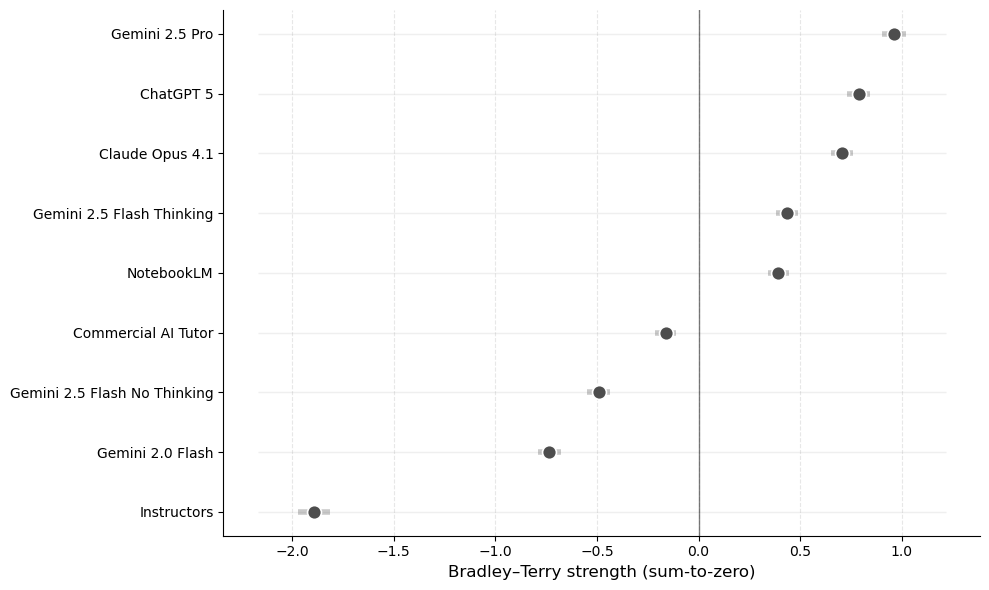

In [4]:
# Run Bradley–Terry analysis for LLM-as-judge results
results = run_model_only_analysis(df)

# Extract and save the BT ranking figure (Figure bt_judge)
fig_bt = results["fig_bt"]
from pathlib import Path
Path("figures").mkdir(exist_ok=True)
fig_bt.savefig("figures/bt_judge.png", dpi=300, bbox_inches="tight")

# Also show in the notebook
fig_bt.show()